This is the third of a series about bitcoin futures on the exchange [Deribit.com](https://www.deribit.com). We will go into detail on a unique financial instrument, the BTC perpetual future. This type of asset isn't commonly used in traditional financial markets, so we do a bit of exploratory data analysis. We'll see that it has some interesting properties that make it possible to use for arbitrage.

- [Part 1 - Getting the data]({% post_url 2019-05-11-bitcoin-futures-arbitrage-part-1 %})
- [Part 2 - Were there arbitrage profits in the past?]({% post_url 2019-05-12-bitcoin-futures-arbitrage-part-2 %})
- [Part 3 - Perpetual futures 101]({% post_url 2019-05-20-bitcoin-futures-arbitrage-part-3 %})

## Perpetual Futures

Deribit offers what are called *perpetual* futures. Eventually we will try to make money using these unique type of futures. But let's try to understand them first.

They are best described as **index matching** futures. It is a product that attempts to always mimic the spot price, but allows an investor to get extremely high leverage. They do this by setting up a futures contract with no settlement date, no expiration and they allow people to trade it freely.

They then compare the market price of this contract to the index. If the perpetual's market price is above the index, the people who are long in the contract have to pay interest to the people who are short. If the perpetual's market price is below the index, the shorts pay the longs. With this set up there is a incentive for the perpetual future market price to converge to the index price. The payments between the contract holders are called **funding payments**.

If the perpetual market price is well below the bitcoin index then the shorts will pay substantial funding payments to the longs. This is a zero sum game. The longs' profits are exactly equal to the shorts' losses. These payments will incentive people close out their short position, in order to avoid the large losses from funding payments. It will also incentivce people to go long for just a short time, in order to get the funding payments for "free". This will increase the demand for long contracts, and cause the market price to go up. This should happen until the market price is in line with the index, and the funding payments are minimal.

The full spec including how the funding payments are calculated can be found [here](https://www.deribit.com/pages/docs/perpetual).

When I refer to a *perpetual* in this document, I mean this.

#### Profit Calculation

Here's a little bit of math so we can understand the instrument we are going to analyse.

Perpetuals are cash settled in BTC, on the price of bitcoin. This is different from a usual futures contract which is cash settled using dollars based on the price of another asset. This adds complexity to profit and loss calculations, because if you are long a future, and the price goes up you not only profit from the increase in in the future's price but also from the increase in the bitcoin used to settle the contract.

Thus Deribit (all all other bitcoin future exchanges I know of) use what are called inverse futures. The specification is laid out in the paper [Inverse Futures in Bitcoin Economy](https://dx.doi.org/10.2139/ssrn.2713755) This simplifies the profit calculation for investors.

The profit on a long perpetual is $A(\frac{1}{P_\text{open}} - \frac{1}{P_\text{close}})$, where $A$ is the amount of your position, $P_\text{open}$ is your entry price and $P_\text{close}$ is your exit price. This is your profit in bitcoins. The profit on a short is thus $-A(\frac{1}{P_\text{open}} - \frac{1}{P_\text{close}})$.

#### A Perpetual Can Act As Spot

This equation gives rise to an interesting idea, namely one can use a perpetual as a drop in replacement for buying or selling in the spot market. 

In order to calculate your profit in dollars you multiply your bitcoin profits by the current price of bitcoin. The profit equation becomes $A(\frac{1}{P_\text{open}} - \frac{1}{P_\text{close}})E$ where $E$ is the exchange price when you close your position.

Now we assume that the perpetual market price is always equal to the bitcoin index. Due to the funding rate pushing the perpetual market price towards the index, it makes sense to think of the perpetual market price as equal to the index, at least in expectation. It also makes sense to use this index as the exchange rate of bitcoins, as it is the average of prices on the largest exchanges. 

With these assumptions the eqation becomes $A(\frac{1}{P_\text{open}} - \frac{1}{P_\text{close}})P_\text{close}$. This simplifies to $\frac{A}{P_\text{open}}(P_\text{close}-P_\text{open})$. The ratio of $A$ to $P_\text{open}$ is best thought of as your **bitcoin exposure** ratio because it is a simple multiplier on $P_\text{close}-P_\text{open}$ which is your profit from buying and holding bitcoin in the spot market.

Notably when $A$ is equal to $P_\text{open}$, (giving a BTC exposure ratio of 1) you linearly profit from increases in the perpetual price.

The same derivation works for a short perpetual, leading to a profit of $-\frac{A}{P_\text{open}}(P_\text{close}-P_\text{open})$

## Exploratory Data Analysis

Now I will do some exploratory data anlysis on the perpetual. The relevant questions are: (1) how well does the perpetual track the index? (2) Is the perpetual price distributed randomly around the index or is it regularly higher or lower? (3) What amount of funding payments should one expect to pay if they hold perpetual contracts?

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from matplotlib import style
import seaborn as sns
from IPython.core.pylabtools import figsize
import warnings
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline
plt.style.use('ggplot')

In [15]:
# Read all historical sales data and index data
df = pd.read_csv('downloads/BTC-PERPETUAL.txt')

In [16]:
# Properly index the pandas dataframe
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.index = df['date']
df = df.drop(columns=['timestamp', 'date'])
df.columns = ['date', 'perpetual', 'index']

In [17]:
df['ratio'] = df['perpetual'] / df['index']

In [18]:
df['funding'] = np.maximum(0.0005, df['ratio'] - 1) +  np.minimum(-0.0005, df['ratio'] - 1)

In [19]:
df_D = df.resample('D').last()
df_5 = df.resample('5Min').last()

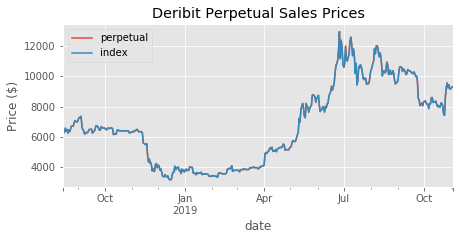

In [20]:
figsize(7,3)
df_D.plot(y=['perpetual', 'index'])
plt.ylabel('Price ($)')
plt.title('Deribit Perpetual Sales Prices')
plt.show()

It appears the perpetual tracks the index quite closely. But let's look at a plot of the ratio of the perpetual price and the index.

## Ratio

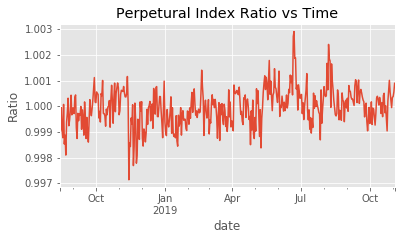

In [21]:
figsize(6,3)
df_D.plot(y='ratio', legend=False)
plt.ylabel('Ratio')
plt.title('Perpetural Index Ratio vs Time')
plt.show()

This looks like a stationary process around a mean value of 1. There appear to be trends in the data; it looks like it is autocorrelated.

Let's plot the autocorrelation.

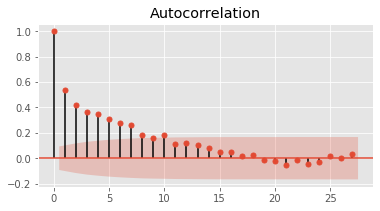

In [22]:
_ = plot_acf(df_D['ratio'])

This is a plot of correlation between days. High autocorrelation means that if the ratio is high one day than we expect it to be high the next. It appears there is significant correlation for a few days (each point is one day forward). But then after a few days there is not significant correlation.

This means that we may be able to use a current perpetual index ratio to predict the ratio for the next few days.

## Distribution

Let's get a sense of how the ratio values are distributed.

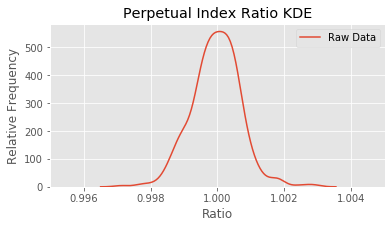

In [23]:
sns.kdeplot(df_D['ratio'], label='Raw Data')
plt.xlabel('Ratio')
plt.ylabel('Relative Frequency')
plt.title('Perpetual Index Ratio KDE')
plt.xlim([0.995,1.005])
plt.show()

The ratios appear to be distributed in a bell like curve around one.

In [24]:
print('Mean ' + str(round(df_D["ratio"].mean(), 5)) + ', SD ' + str(round(df_D["ratio"].std(), 5)) + ', Skew ' + str(round(scipy.stats.skew(df_D["ratio"]), 5)) + ', Kurtosis ' + str(round(scipy.stats.kurtosis(df_D["ratio"]), 5)))

Mean 0.99996, SD 0.00073, Skew 0.06577, Kurtosis 1.37198


A normal curve has a kurtosis and skew of 0. Ours is slightly leptokurtic.

## Funding Rates

Before I told you that funding rates are used to balance the market price of the perpetual in a hand wavey sort of way. Now lets look at the formula.

According to https://www.deribit.com/pages/docs/perpetual, the funding rate is calculated in two steps.

(1) The percent differece between the perpetual market price and the index is found. This equals our ratios from above - 1. (Example: A ratio of 1.01, means the perpetual is 1% higher in price.)
(2) The funding rate is sort of a clamped version of the percent differene. You take any differnce of 0.0005 or smaller and set it to zero.
(3) This equals the **8 hour** funding rate. 

Your funding payments are then calculated as

$$\text{contract amount} \times \text{funding rate} \times \text{number of 8 hour periods you held the contract}$$

Below I graphed how the funding rate changes as the ratio of the prices changes.

I also annualized the funding rate for ease of comprehension.

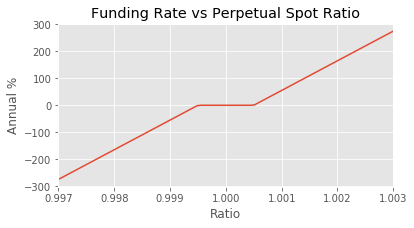

In [27]:
xs = np.linspace(0.997, 1.003, 100)
ys = (np.maximum(0.0005, xs - 1) +  np.minimum(-0.0005, xs - 1)) * 3 * 365 * 100
plt.plot(xs, ys)
plt.ylabel('Annual %')
plt.xlabel('Ratio')
plt.xlim([0.997,1.003])
plt.title('Funding Rate vs Perpetual Spot Ratio')
plt.show()
#plt.savefig('funding_rate.png', bbox_inches='tight')

We can see that the funding rate drastically varies with the price ratios. If the ratio was at a steady 1.003 (a difference of only 0.3%), then the annual funding rate would be at almost 300%.

### Historical Data

Now lets see what the funding rates would have been, given our historical price data.

In [31]:
df_5['annual funding'] = df_5['funding'] * 3 * 365 * 100
df_D['annual funding'] = df_D['funding'] * 3 * 365 * 100

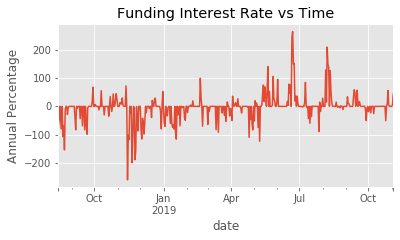

In [36]:
df_D.plot(y='annual funding', legend=False)
plt.ylabel('Annual Percentage')
plt.title('Funding Interest Rate vs Time')
plt.show()

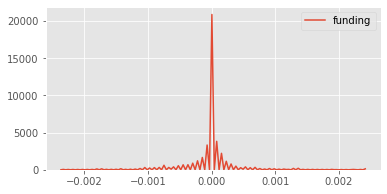

In [38]:
sns.kdeplot(df_D['funding'])
plt.show()

And here's the fequency of ratios, along with the funding rates that they cause.

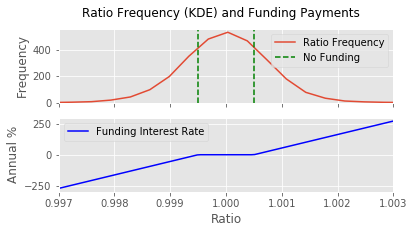

In [39]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Ratio Frequency (KDE) and Funding Payments')
sns.kdeplot(df_5['ratio'], label='Ratio Frequency', ax=ax1)
ax1.set_ylabel('Frequency')
ax1.axvline(x=0.9995, color='g', linestyle='--', label='No Funding')
ax1.axvline(x=1.0005, color='g', linestyle='--')
ax1.legend()
xs = np.linspace(0.997, 1.003, 100)
ys = (np.maximum(0.0005, xs - 1) +  np.minimum(-0.0005, xs - 1)) * 3 * 100 * 365
ax2.plot(xs, ys, label='Funding Interest Rate', color='b')
ax2.set_ylabel('Annual %')
ax2.set_xlabel('Ratio')
plt.xlim([0.997,1.003])
plt.legend()
#plt.savefig('funding_rate_frequency.png', bbox_inches='tight')
plt.show()

# Arbitrage with the Perpetual

Here is the strategy. We have seen from Part 1 that futures contracts converge to a ratio of 1. The perpetual price vs index price ratio also hovers around 1. Thus if there is a large differce in the futures price and the perpetual price, we should be able to buy one and sell the other, to make money when the prices eventually converge.

Let's look at a specific example.

I recorded the market prices at Sunday, May 12, 2019 8:37:20.520 AM GMT. This was just a random moment I picked over the past 4 months.

The prices were as follows:

Instrument | Price
--- | ---
BTC-27SEP19 | \\$7248.50
BTC-28JUN19 | \\$7270.13
BTC-PERPETUAL | \\$7325.88
BTC Index | \\$7335.49

In this example, if we assume that the BTC-PERPETUAL and the BTC-28JUN19 will eventuall converge to the same price (the price of the index) then we can make money. We buy BTC-28JUN19 for \\$7270.13 and sell the BTC-PERPETUAL for \\$7325.88.

We will make a consisten profit, regardless of how the price of BTC changes. You can see that in the example below

In [21]:
start_perpetual_price = 7325.88
start_june_future_price = 7270.13
start_index_price = 7335.49

end_index_prices = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000])

short_profits = start_index_price - end_index_prices
long_profits = end_index_prices - start_june_future_price

total_profits = np.round(short_profits + long_profits, 2)

for i, value in enumerate(end_index_prices):
    print(f'Future Index Price: ${value}    Profit: ${total_profits[i]}')

print((f'\nIndex Price - Future Price = '
       f'${start_index_price} - ${start_june_future_price} = '
       f'${round(start_index_price - start_june_future_price, 2)}'))

Future Index Price: $1000    Profit: $65.36
Future Index Price: $2000    Profit: $65.36
Future Index Price: $3000    Profit: $65.36
Future Index Price: $4000    Profit: $65.36
Future Index Price: $5000    Profit: $65.36
Future Index Price: $6000    Profit: $65.36
Future Index Price: $7000    Profit: $65.36
Future Index Price: $8000    Profit: $65.36
Future Index Price: $9000    Profit: $65.36

Index Price - Future Price = $7335.49 - $7270.13 = $65.36


The problem, is that the perpetual doesn't perfectly line up with the index. Thus they might not completly converge. There is also the issue of funding payments. We saw above the huge variablitiy in funding payments. If you get unlucky, the funding payments will completely take away this profit.

There are also other factors like counterparty risk. This is a real problem. Bitcoin exchanges are known to get hacked, or just lose people's money. We should take this into acount when evaluating any strategy involving cryptocurrency exchanges. We should expect a higher risk premium, to compensate for this higher counterparty risk that doesn't typically arise in traditional asset exchanges.

Next we will look at simulating these risks to get a probability distribution of potential profit situations. We will try to see if the variability in the perpetual index ratio and the funding rate will take away from our expected $65.36 of profit.